<a href="https://colab.research.google.com/github/andreaco/andreaco.github.io/blob/main/ACTAM_GeneticAlgorythmStudy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Genetic Algorythm Drum Study

## Imports and Downloads

Here are the libraries that we used for doing this analysis 

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import IPython.display as ipd
from fractions import gcd

import random

## Audio Preview

Here we defined some utility functions to create an audio representation

In [21]:
def kick_sound(t, position):
  # Amplitude and pitch envelope parameters
  tau = 0.1
  A = 0.9

  # Kick Start and Step Function
  t_o = t - position
  step = np.zeros(t_o.shape)
  step[t_o > 0] = 1

  # Amplitude envelope
  a1 = step * A * np.exp(-t_o/tau)

  # Pitch envelope
  a2 = step * np.exp(-t_o/tau)
  
  return a1 * np.sin(2 * np.pi * (40 + a2 * 550) * t_o)

def snare_sound(t, position):
  # Amplitude and pitch envelope parameters
  tau = 0.01
  A = 0.9

  # Kick Start and Step Function
  t_o = t - position
  step = np.zeros(t_o.shape)
  step[t_o > 0] = 1

  # Amplitude envelope
  a1 = step * A * np.exp(-t_o/tau)

  # Pitch envelope
  a2 = step * np.exp(-t_o/tau)
  
  noise = np.random.random(t.shape)
  return a1 * noise

def pattern2audio(pattern, audio_len = 4.0, fs=44100):
  """Given a pattern represented as 0s and 1s, create an audio representation"""
  # time axis
  t = np.arange(0, audio_len, 1.0 / fs);
  # For each step, marks its time relative position
  onsets = np.arange(0, audio_len, audio_len/len(pattern))

  # Audio representation
  x = np.zeros(t.shape)

  # For each step in the pattern, add kick if step is 1
  for i in range(len(pattern)):
    if(pattern[i] == 1):
      x += 0.5*kick_sound(t, onsets[i])
    if(i % 2 == 0):
      x += 0.5*snare_sound(t, onsets[i])
  ipd.display(ipd.Audio(data=x, rate=fs))
  return (t, x)

## Feature Definition

Here we defined some functions that use *pretty-midi* library to parse the MIDIs and quantize them to the representation that we used in our previous feature analysis 

In [22]:
def distance(pattern): 
  """
  Returns the distance between consecutive onsets,
  accounting for the distance between the last and the first
  """
  n = len(pattern)  
  ons = np.nonzero(pattern)[0]

  if len(ons) > 0:
    last = n+ons[0]
  else:
    last = None
  return np.diff(ons, append=last)


def IOI(pattern):
  """
  Returns the PDF of distances between onsets
  """
  
  g = distance(pattern)
  
  unique, counts = numpy.unique(g, return_counts=True)

  N = np.sum(counts) # N is the number of intervals (== numbero of onsets)
  ans = [0]*(len(pattern) + 1) # Len of pattern + 1, taking into account seq with only one onset (distance 16 needs index 16)
  for i in range(len(unique)):
    ans[unique[i]] = counts[i] / N
  return ans


By studying [this paper](https://www.sciencedirect.com/science/article/abs/pii/S0010027720300524), we decided to use 3 different kind of representations to compute our features:
> * **p**: A list of quantized beats, containing 1s in onset position and 0s otherwhise (i.e. [1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0] represent a 4 on 4 beat with just 4 onsets)
* **x**: A list containing the onsets position in a relative time scale between 0 and 1. (i.e. [0.0, 0.25, 0.5, 0.75] is the representation of the rhythm stated before)
* **z**: Similar to the **x** representation but with the exception that the beats are wrapped around a unit circle.

In [23]:
def p2x(p):
  """
  Given a beat in p representation, returns the relative x representation
  """
  return np.nonzero(p)[0] / len(p)

def x2z(x):
  """
  Given a beat in x representation, returns the relative z representation
  """
  return np.exp(2*np.pi*1j*x)

By using the previously stated representation we are able to compute a different number of features.

In [24]:
def balance(z):
  """
  Balance description
  """
  N = len(z)
  if (N == 0): return 0
  else:             return 1 - np.abs(np.sum(z)) / N

def evenness(z):
  """
  Evenness description
  """
  N = len(z)
  k = np.arange(N)

  if (N == 0): return 0
  else:        return np.abs(np.sum(z*np.exp(-2*np.pi*1j*k / N)))/N

def distance(pattern): 
  """
  Returns the distance between consecutive onsets,
  accounting for the distance between the last and the first
  """
  n = len(pattern)  
  ons = np.nonzero(pattern)[0]

  if len(ons) > 0:
    last = n+ons[0]
  else:
    last = None
  return np.diff(ons, append=last)


def IOI(pattern):
  """
  Returns the PDF of distances between onsets
  """
  
  g = distance(pattern)
  
  unique, counts = np.unique(g, return_counts=True)

  N = np.sum(counts) # N is the number of intervals (== numbero of onsets)
  ans = [0]*(len(pattern) + 1) # Len of pattern + 1, taking into account seq with only one onset (distance 16 needs index 16)
  for i in range(len(unique)):
    ans[unique[i]] = counts[i] / N
  return ans


def entropy(ioi):
  N = len(ioi)
  ioi += np.finfo(float).eps
  return - np.sum(ioi*np.log(ioi)) / np.log(N)

## Genetic Simulation

[Crossover Functions](https://en.wikipedia.org/wiki/Crossover_(genetic_algorithm))

In [25]:
def single_point_crossover(a, b, crossover_point = 0.5):
  M = int(np.floor(crossover_point * len(a)))
  child = np.zeros(a.shape)
  child[0:M] = a[0:M]
  child[M:]  = b[M:]
  return child

def two_point_crossover(a, b, start, end):
  s = int(np.floor(start * len(a)))
  e = int(np.floor(end   * len(a)))
  child = np.copy(a)
  child[s:e] = b[s:e]
  return child

[Mutation](https://en.wikipedia.org/wiki/Mutation_(genetic_algorithm))

In [26]:
def bitstring_mutation(p):
  N = len(p)
  prob = 1 / N
  rng = np.random.rand(N)
  p[rng < prob] = (p[rng < prob] + 1) % 2

  return p

[Selection](https://www.sciencedirect.com/science/article/abs/pii/S0378437111009010)

In [27]:
# Most Fittest survive
def most_fittest(pop):
  
  selected = pop[:]
  scores   = np.zeros((pop.shape[0],))
  tot_fitness = 0

  for i, element in enumerate(pop):
    element_fit = fitness(element)
    scores[i] = element_fit
    tot_fitness += element_fit
  
  #Sorts pop by value and creates an array with the sorte by value pop
  selected = np.array([x for _, x in sorted(zip(scores, pop), reverse=True,key=lambda pair: pair[0])])
  sorted_scores = sorted(scores, reverse=True)

  trim = int(np.floor(survival_rate*selected.shape[0]))
  if (trim % 2 != 0):
    trim -= 1;
  selected = selected[0:trim]
  scores   = scores[0:trim]
  return selected, scores

# Roulette wheel with stochastic acceptance
def selection(pop):
  
  selected = pop.copy()
  scores   = np.zeros((selected.shape[0],))
  num_survivors = int(np.floor(selected.shape[0] * survival_rate))

  for i, element in enumerate(selected):
    element_fit = fitness(element)
    scores[i] = element_fit
  
  survival_prob = scores / np.max(scores)
  
  survived = np.zeros((num_survivors, selected.shape[1]), dtype=np.int)

  for i in range(num_survivors):
    index = np.random.randint(0, selected.shape[0]-1)
    while(np.random.rand() > survival_prob[index]):
      index = np.random.randint(0, selected.shape[0]-1)
    survived[i] = selected[index]
    selected = np.delete(selected, index, axis=0);
  
  scores   = np.zeros((survived.shape[0],))

  for i, element in enumerate(survived):
    scores[i] = fitness(element)
    
  return survived, scores



In [28]:
# Mating using Two Point Crossover function
def mating(a, b):
  randomA = random.random()
  randomB = random.random()
  start, end = min(randomA, randomB), max(randomA, randomB)
  return two_point_crossover(a, b, start, end), two_point_crossover(b, a, start, end)

"""
# Mating using Single Point Crossover function
def mating(a, b):
  start = random.random()
  return single_point_crossover(a, b, start), single_point_crossover(b, a, start)
"""

def fitness(p):
  #Feature Extraction
  x = p2x(p)
  z = x2z(x)

  b = balance(z)
  e = evenness(z)
  h = entropy(IOI(p))

  return b*e*h

In [29]:
def random_seq(n_steps):
  return [random.randint(0, 1)  for _ in range(n_steps)]

def random_pop(n_indiv=5000, n_steps=16):
  return np.array([random_seq(n_steps) for _ in range(n_indiv)])

def crossover(selected):
  N = len(selected)
  #np.random.shuffle(selected)
  offspring = selected.copy()
  for i in range(0, N-1, 2):  # check if N-1 avoid out of range?
    if (np.random.rand() < crossover_probability):
      child1, child2 = mating(selected[i], selected[i+1])
      offspring[i]   = child1
      offspring[i+1] = child2

  return offspring
  
def mutation(pop):
  for i in range(len(pop)):
    if (np.random.rand() < mutation_probability):
      pop[i] = bitstring_mutation(pop[i])
  return pop

crossover_probability = 0.99
mutation_probability = 0.01

survival_rate = 0.99

KeyboardInterrupt: ignored

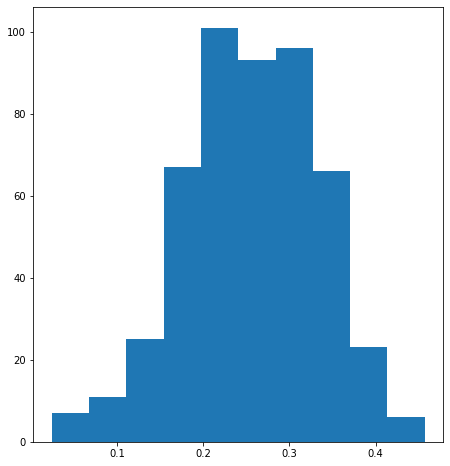

In [30]:
np.random.seed(69)
pop = random_pop(500, 16)

pop, scores = selection(pop)

plt.figure(figsize=(25, 8))
plt.subplot(131)
plt.hist(scores);

history = []
while np.mean(np.array(scores) < 0.5) and len(history) < 10000:
  if(len(pop) < 20):
    pop = np.append(pop, random_pop(5, 16), axis=0)
  pop, scores = selection(pop)
  pop = crossover(pop)
  pop = mutation(pop)
  history.append(np.mean(np.array(scores)))


print(pop)

plt.subplot(132)
plt.plot(history);
plt.title("Mean Fitness")
plt.subplot(133)
plt.hist(scores);

In [ ]:
np.append(random_pop(500, 32), random_pop(500, 32), axis=0)

In [ ]:
print(pop)
for p in pop:
  print("Fitness: {}".format(fitness(p)))
  pattern2audio(p, audio_len=6.0, fs=16000)

In [ ]:
pop = random_pop(5000, 32)

pop, scores = selection(pop)
plt.hist(scores);

NameError: ignored

0.4771204389269347